# scAtlasVAE - CD8+ T cell transfer Vignette

In this vignette we will show how to use the T-DeepInsight to map the GEX from the query dataset to the reference dataset.

In [45]:
import sys
# import atlasvae
import matplotlib
import matplotlib.pyplot as plt
import scanpy as sc
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size']= 14 

print("Python version")
print(sys.version)
print("Version info.")
print(sys.version_info)

matplotlib.rcParams['font.family'] = 'Arial'
matplotlib.rcParams['font.size'] = '10'
matplotlib.rcParams['font.weight'] = 100
matplotlib.rcParams['axes.linewidth'] = 0.5
matplotlib.rcParams['axes.edgecolor'] = "#000000"

import seaborn as sns

def plot_a_by_b(adata, a, b):
   B = pd.DataFrame(
       list(adata.obs[list(map(lambda x: type(x) == str, adata.obs[a]))].groupby(b).agg(
           {a:lambda x: dict(Counter(x))
           }).iloc[:,0])).fillna(0)
   B = pd.DataFrame((B.to_numpy().T / B.to_numpy().sum(1)).T,columns=B.columns)
   B.insert(0,b,pd.Categorical(adata.obs[b]).categories)
   ax = B.plot(x=b, kind='bar', stacked=True, color=sc.pl._tools.scatterplots._get_palette(adata, a))
   return B, ax


def createFig(figsize=(8, 4)):
    fig,ax=plt.subplots()           
    ax.spines['right'].set_color('none')     
    ax.spines['top'].set_color('none')
    #ax.spines['bottom'].set_color('none')     
    #ax.spines['left'].set_color('none')
    for line in ax.yaxis.get_ticklines():
        line.set_markersize(5)
        line.set_color("#585958")
        line.set_markeredgewidth(0.5)
    for line in ax.xaxis.get_ticklines():
        line.set_markersize(5)
        line.set_markeredgewidth(0.5)
        line.set_color("#585958")
    ax.set_xbound(0,10)
    ax.set_ybound(0,10)
    fig.set_size_inches(figsize)
    return fig,ax

def createSubplots(nrow,ncol, figsize=(8,8),gridspec_kw={}):
    fig,axes=plt.subplots(nrow, ncol, gridspec_kw=gridspec_kw)
    for ax in axes.flatten():
        ax.spines['right'].set_color('none')     
        ax.spines['top'].set_color('none')
        for line in ax.yaxis.get_ticklines():
            line.set_markersize(5)
            line.set_color("#585958")
            line.set_markeredgewidth(0.5)
        for line in ax.xaxis.get_ticklines():
            line.set_markersize(5)
            line.set_markeredgewidth(0.5)
            line.set_color("#585958")
    fig.set_size_inches(figsize)
    return fig,axes

import copy
def normalize_non_inplace(adata):
    adata.layers['normalized'] = copy.deepcopy(adata.X)
    sc.pp.normalize_total(adata, layer='normalized')
    sc.pp.log1p(adata, layer='normalized')
    
subtype_color = {
    'Tn':'#CEBF8F',
    'Tcm':'#ffbb78',
    'Early Tcm/Tem':'#ff7f0e',
    'GZMK+ Tem':'#d62728',
    'GNLY+ Temra':'#8c564b',
    'CMC1+ Temra':'#e377c2',
    'ZNF683+ Teff':'#C5B0D5',
    'MAIT':'#17becf',
    'ILTCK':'#aec7e8',
    'ITGAE+ Trm':'#279e68',
    'CREM+ Trm':'#aa40fc',
    'ITGB2+ Trm':'#5ce041',
    'Tpex':'#ff9896',
    'GZMK+ Tex':'#6f3e7c',
    'ITGAE+ Tex':'#e8c0ba',
    'S100A11+ Tex':'#b5bd61',
    'MACF1+ T':'#3288c9',
    'Cycling T':'#f7b6d2'
}

Python version
3.9.18 (main, Nov  2 2023, 17:01:24) 
[Clang 14.0.0 (clang-1400.0.29.202)]
Version info.
sys.version_info(major=3, minor=9, micro=18, releaselevel='final', serial=0)


## Load dataset

Load the reference dataset

In [27]:
adata_cd8_reference = sc.read_h5ad("./data/huARdb_v2_GEX.CD8.hvg4k.20231116.h5ad")

Load the query dataset

In [8]:
adata_bassez_cohort1 = sc.read_h5ad("./data/transfer_data/final/Bassez_BC.cohort1.CD8_T.h5ad")
adata_bassez_cohort2 = sc.read_h5ad("./data/transfer_data/final/Bassez_BC.cohort2.CD8_T.h5ad")
adata_bi = sc.read_h5ad("./data/transfer_data/final/Bi_RCC.CD8_T.h5ad")
adata_caushi = sc.read_h5ad('./data/transfer_data/final/Caushi_NSCLC.CD8_T.h5ad')
adata_liu = sc.read_h5ad("./data/transfer_data/final/Liu_TNBC.CD8_T.h5ad)
adata_luoma_pbmc = sc.read_h5ad("./data/transfer_data/final/Luoma_HNSCC_TIL.CD8_T.h5ad")
adata_luoma_til = sc.read_h5ad("./data/transfer_data/final/Luoma_HNSCC_PBMC.CD8_T.h5ad"")
adata_smillie = sc.read_h5ad("./data/transfer_data/final/Smillie_UC.CD8_T.h5ad")
adata_watson = sc.read_h5ad("./data/transfer_data/final/Watson_MELA.CD8_T.h5ad"")
adata_zhang = sc.read_h5ad("./data/transfer_data/final/Zhang_LC.CD8_T.h5ad")

Merging query dataset

In [ ]:
merged_adata_for_transfer = sc.concat([
    adata_bassez_cohort1,
    adata_bassez_cohort2,
    adata_bi,
    adata_caushi,
    adata_liu,
    adata_luoma_pbmc,
    adata_luoma_til,
    adata_smillie,
    adata_watson,
    adata_zhang
])

## Transfer query datasets to reference using pretrained model weights

pretrained_state_dict: `./data/huARdb_v2_GEX.CD8.hvg4k.20231116.retrained.supervised.model`
This is a pretrained model weights for all T cell subtypes

In [ ]:
state_dict = torch.load("./data/huARdb_v2_GEX.CD8.hvg4k.20231116.retrained.supervised.model")
merged_adata_for_transfer.obs['cell_subtype_3'] = 'undefined'
merged_adata_for_transfer = merged_adata_for_transfer[:,adata_cd8_reference.var.index]
merged_adata_for_transfer.obs['cell_subtype_3'] = pd.Categorical(
    list(merged_adata_for_transfer.obs['cell_subtype_3']),
    categories=pd.Categorical(adata_cd8_reference.obs['cell_subtype_3']).categories
)


merged_adata_for_transfer.obs['study_name'] = 'Lechner_2023'
vae_model_transfer =  tdi.model.VAEModel(
    adata=merged_adata_for_transfer,
    pretrained_state_dict=state_dict['model_state_dict'],
    **state_dict['model_config']
)
from t_deep_insight.utils._umap import transfer_umap
merged_adata_for_transfer.obsm['X_gex'] = vae_model_transfer.get_latent_embedding()
merged_adata_for_transfer.obsm['X_umap'] = transfer_umap(
    adata_cd8_reference.obsm['X_gex'],
    adata_cd8_reference.obsm['X_umap'],
    merged_adata_for_transfer.obsm['X_gex'],
    method='knn',
    n_neighbors=3
)['embedding']
df = vae_model_transfer.predict_labels(return_pandas=True)
merged_adata_for_transfer.obs['cell_subtype_3'] = list(df['cell_subtype_3'])


pretrained_state_dict: `./data/20231210Tex.retrain_vae_for_transfer.model`
This is a pretrained model weights for all Tex subtypes

In [ ]:

import torch
merged_adata_for_transfer_tex = merged_adata_for_transfer[list(map(lambda x: 'Tex' in x, merged_adata_for_transfer.obs['cell_subtype_3']))]
merged_adata_for_transfer_tex.obs['cell_subtype_4'] = 'undefined'
merged_adata_for_transfer_tex.obs['cell_subtype_4'] = pd.Categorical(
    list(merged_adata_for_transfer_tex.obs['cell_subtype_4']),
    categories=adata_tex.obs['cell_subtype_4'].cat.categories
)

state_dict = torch.load("./data/20231210Tex.retrain_vae_for_transfer.model")
vae_model_transfer =  tdi.model.VAEModel(
    adata=merged_adata_for_transfer_tex,
    pretrained_state_dict=state_dict['model_state_dict'],
    **state_dict['model_config']
)

merged_adata_for_transfer_tex.obsm['X_retrain_GEX'] = vae_model_transfer.get_latent_embedding()
from t_deep_insight.utils._umap import transfer_umap
merged_adata_for_transfer_tex.obsm['X_retrain_umap'] = transfer_umap(
    adata_tex.obsm['X_retrain_GEX'],
    adata_tex.obsm['X_retrain_umap'],
    merged_adata_for_transfer_tex.obsm['X_retrain_GEX'],
    method='knn',
    n_neighbors=3
)['embedding']

merged_adata_for_transfer_tex.obs['cell_subtype_4'] = vae_model_transfer.predict_labels(return_pandas=True)['cell_subtype_4']

## Visualization and Analysis of the Transfered dataset

### Transfered cell subtypes for all query datasets

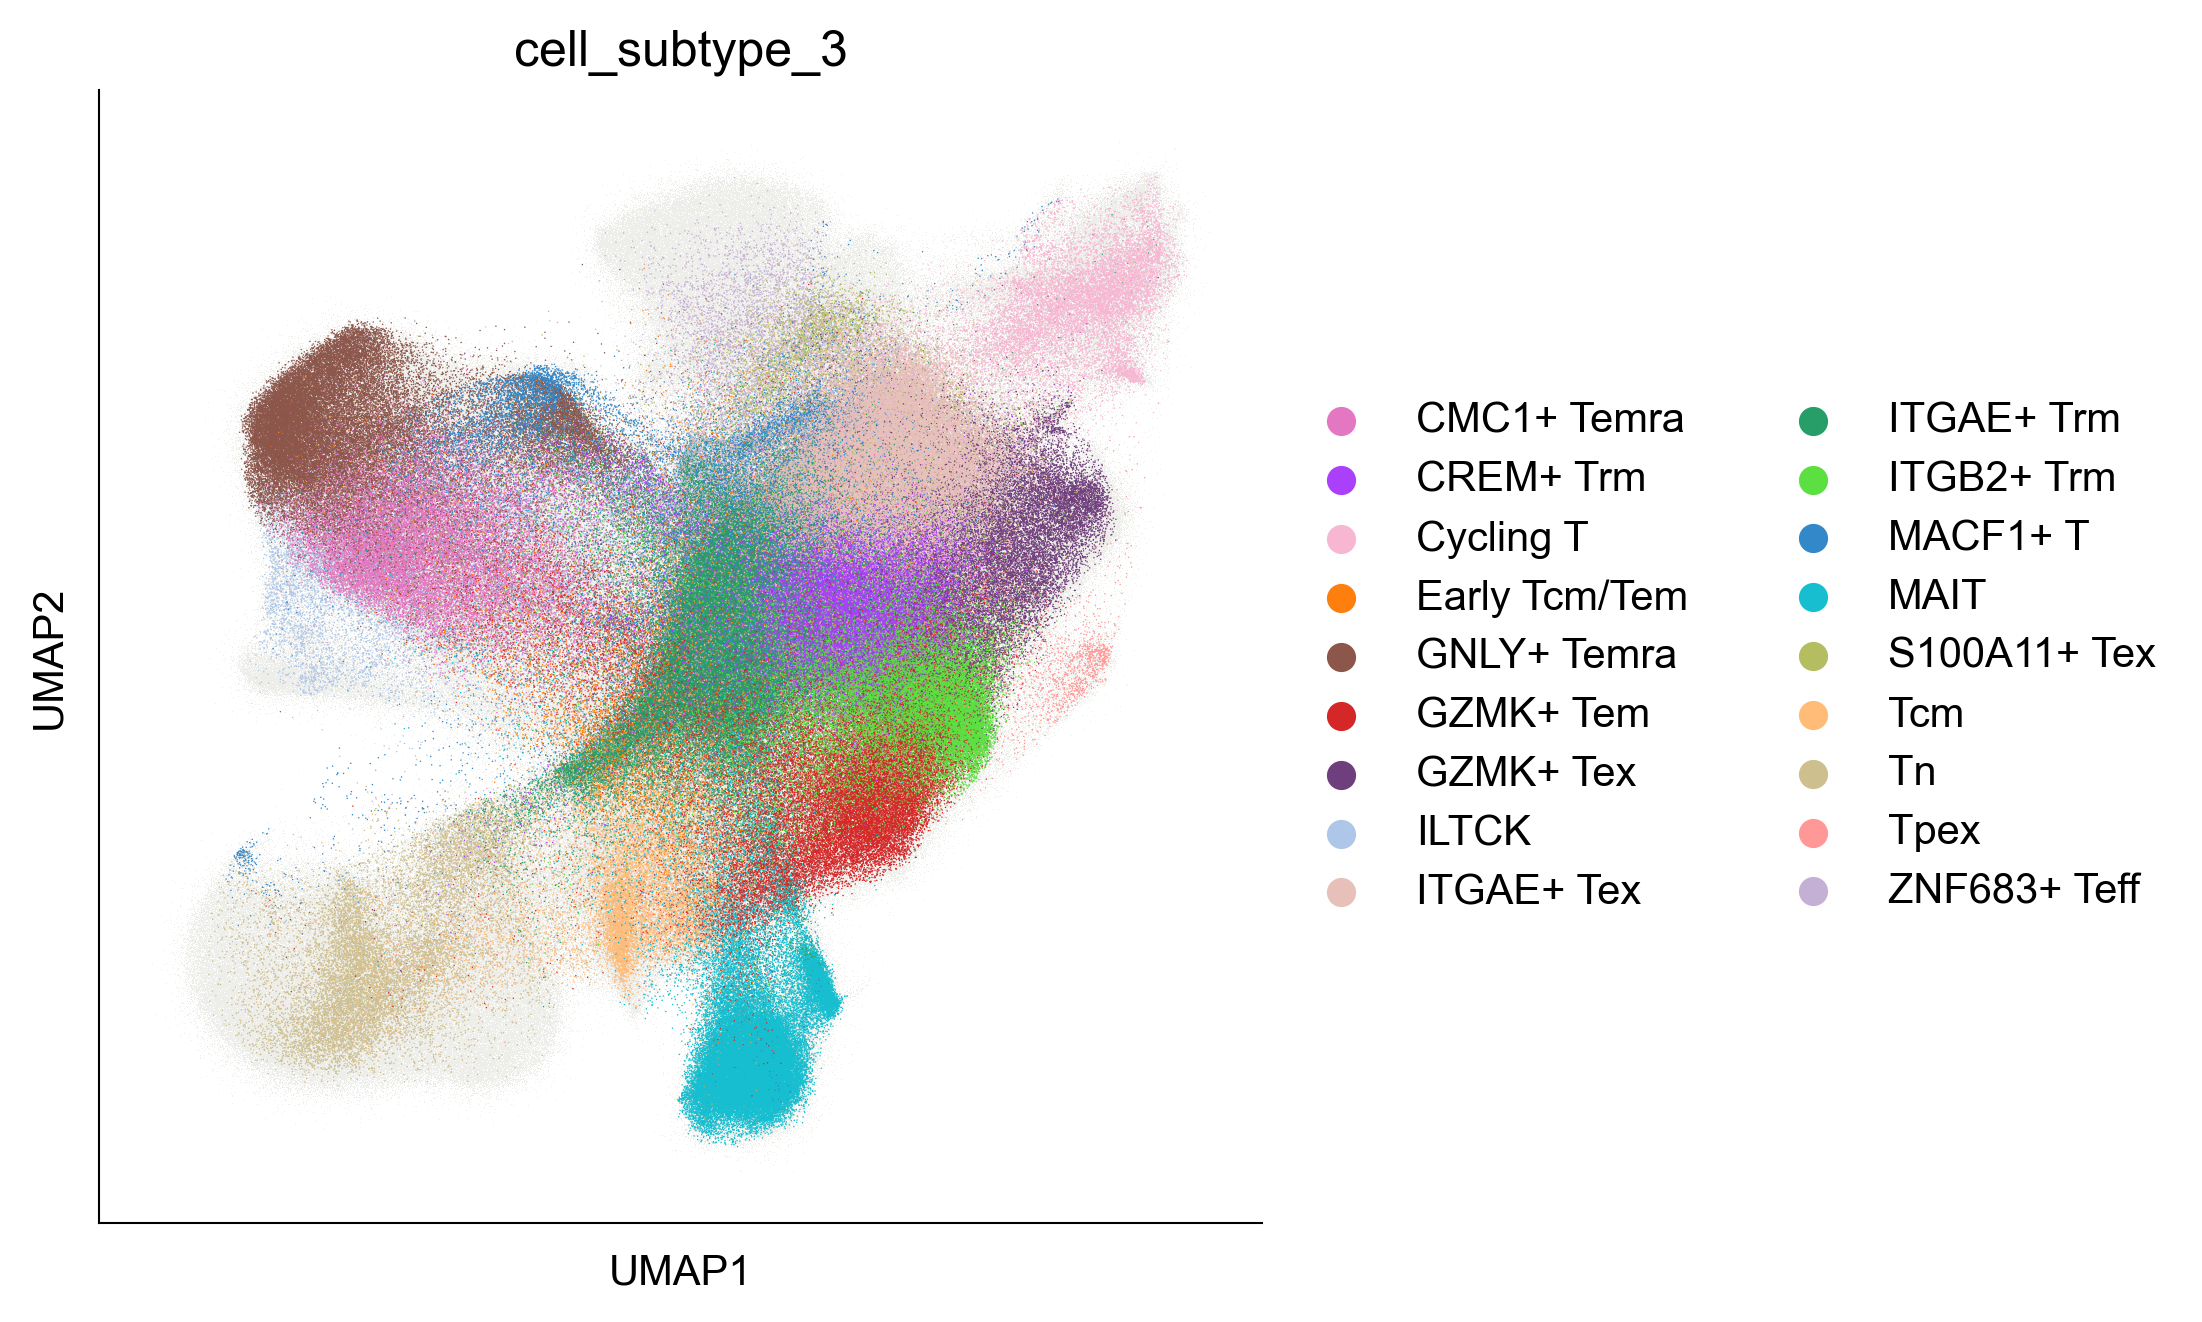

In [104]:
fig,ax=createFig(figsize=(5,5))
obsm = adata_cd8_reference.obsm['X_umap']
ax.scatter(
    obsm[:,0],
    obsm[:,1],
    lw=0,
    s=0.05,
    color='#EDEDEA'
)
sc.pl.umap(
    merged_adata_for_transfer,
    color='cell_subtype_3', 
    palette=subtype_color,
    ax=ax,
    s=0.5
)
plt.show()

### Transfered batches for all query datasets

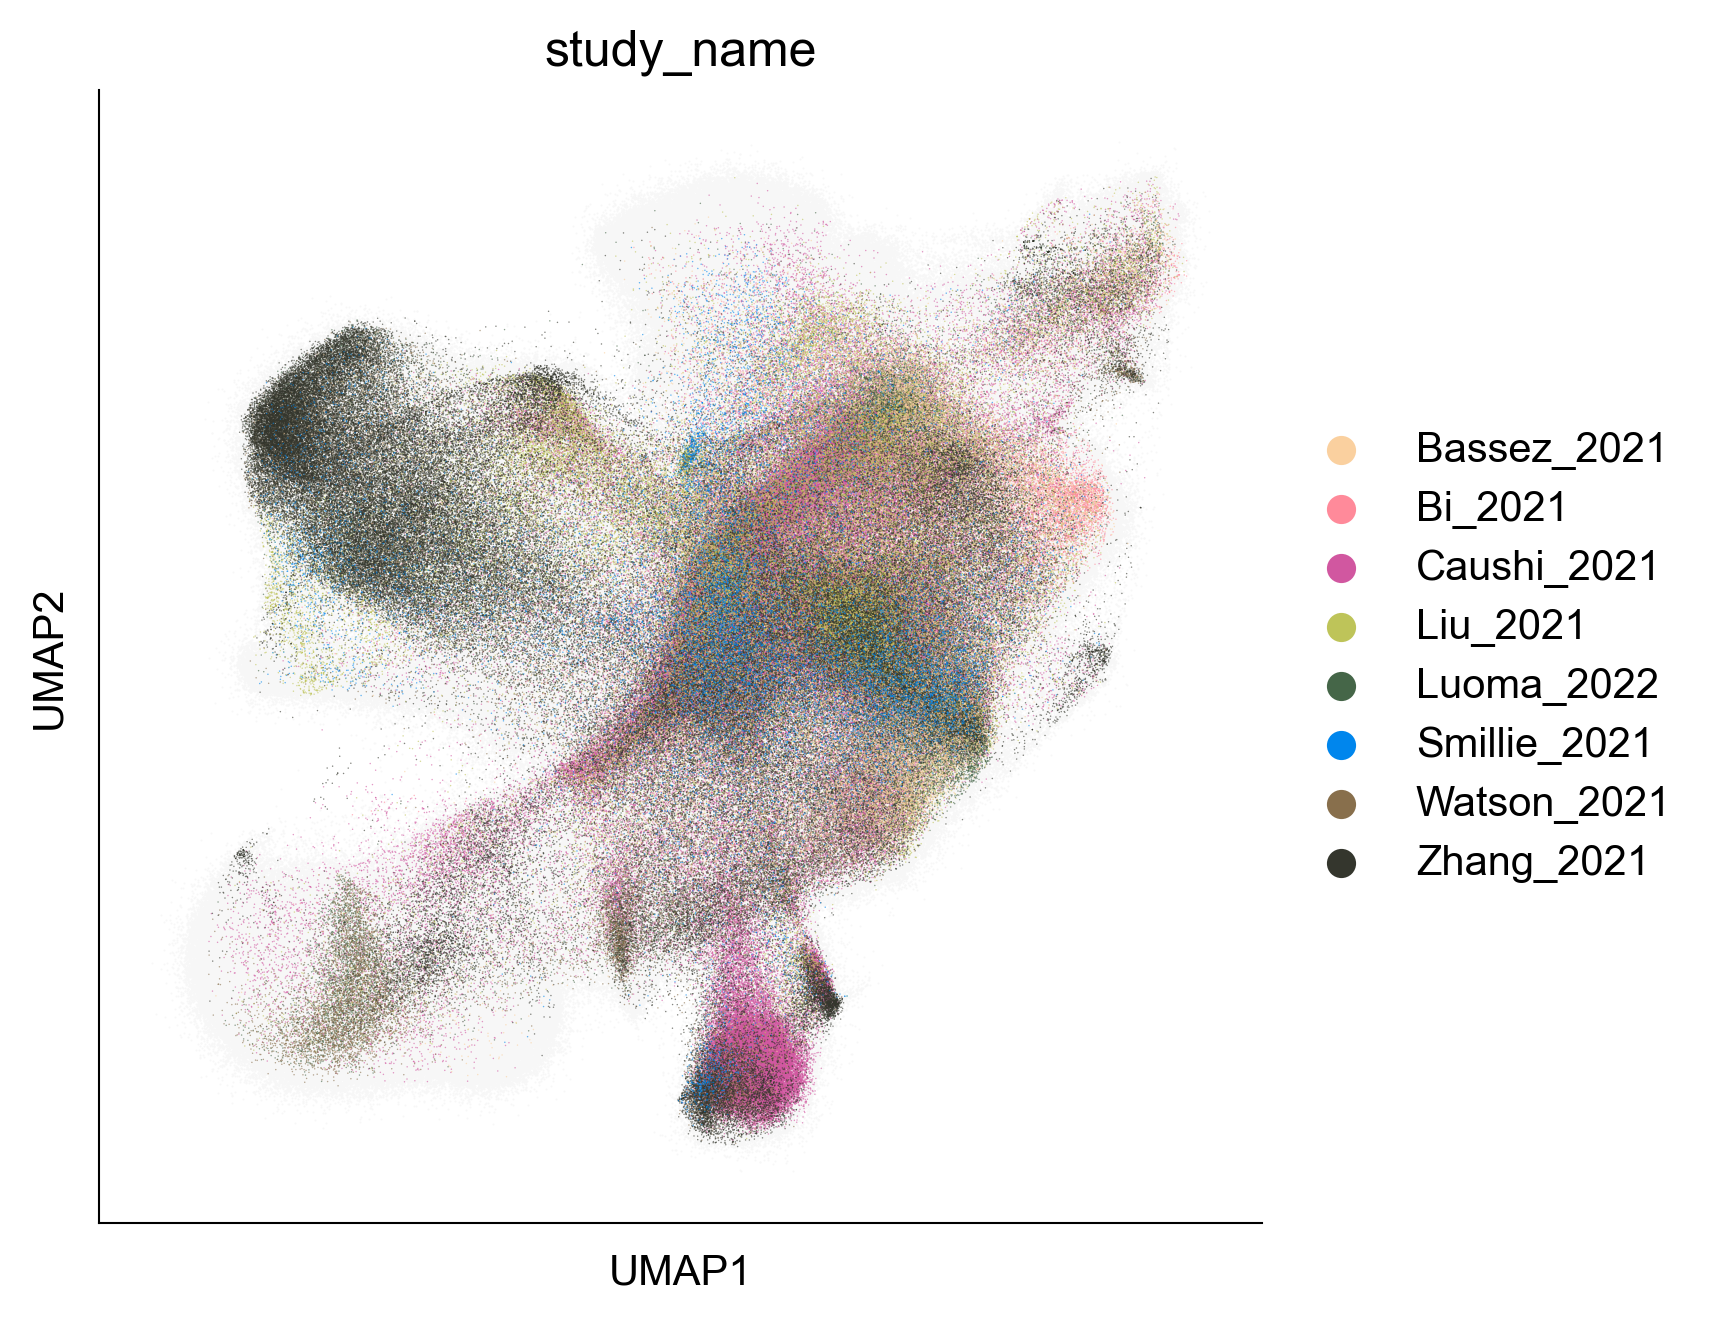

In [31]:
fig,ax=createFig(figsize=(5,5))
ax.scatter(
    obsm[:,0],
    obsm[:,1],
    lw=0,
    s=0.2,
    color='#F7F7F7'
)
sc.pl.umap(
    merged_adata_for_transfer,
    color='study_name', 
    palette=sc.pl.palettes.godsnot_102[56:],
    ax=ax,
    s=0.5,
    alpha=0.6
)
plt.show()

### Gene expression of the transfered cell subtypes

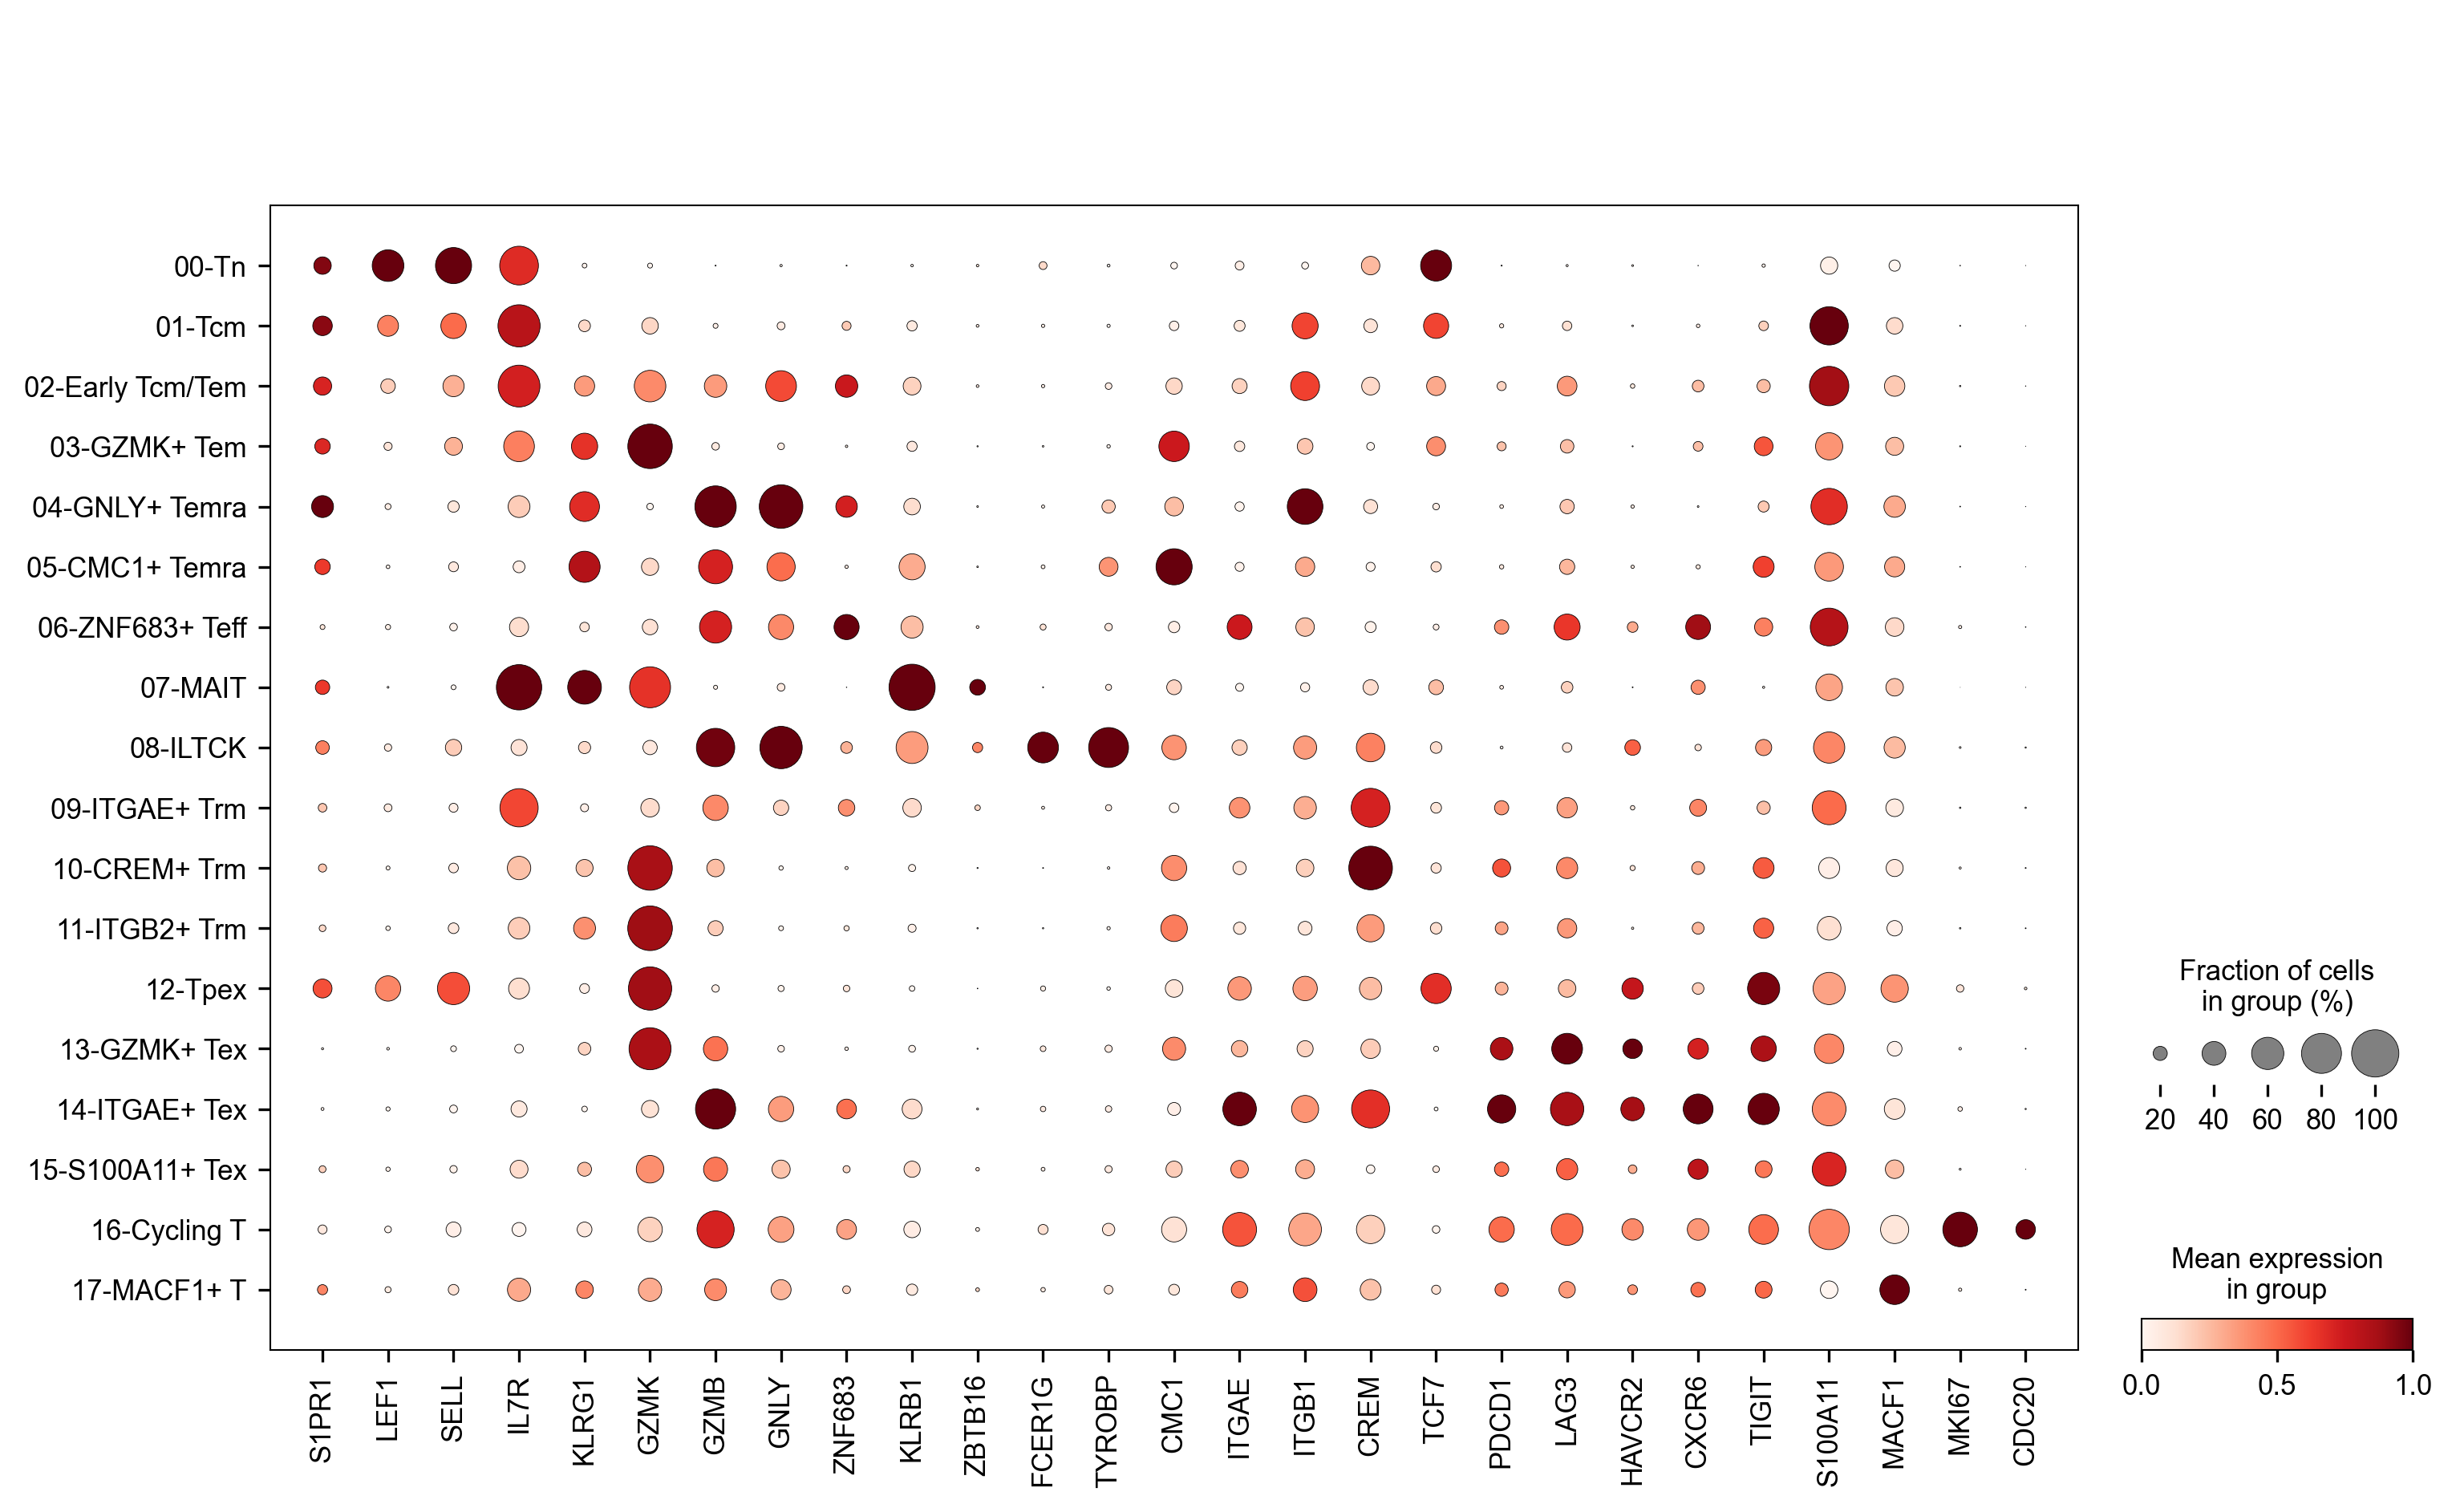

In [37]:
l = ['Tn', 
'Tcm', 
'Early Tcm/Tem', 
'GZMK+ Tem', 
'GNLY+ Temra', 
'CMC1+ Temra', 
'ZNF683+ Teff',
'MAIT', 
'ILTCK', 
'ITGAE+ Trm', 
'CREM+ Trm', 
'ITGB2+ Trm', 
'Tpex', 
'GZMK+ Tex', 
'ITGAE+ Tex', 
'S100A11+ Tex', 
'Cycling T', 
'MACF1+ T']
normalize_non_inplace(merged_adata_for_transfer)
m = dict(zip(l, list(map(lambda x: f'{x[0]:02d}' + "-" + x[1], enumerate(l)))))
merged_adata_for_transfer.obs['cell_subtype_3_'] = list(map(m.get, merged_adata_for_transfer.obs['cell_subtype_3']))
sc.pl.dotplot(merged_adata_for_transfer, ["S1PR1", "LEF1", "SELL", "IL7R", 
                                     "KLRG1", "GZMK", "GZMB", "GNLY", "ZNF683",
                                     "KLRB1", "ZBTB16", "FCER1G", "TYROBP", 'CMC1',
                                     "ITGAE", "ITGB1", "CREM", 
                                     "TCF7", "PDCD1", "LAG3", 'HAVCR2',
                                     "CXCR6", "TIGIT", "S100A11",
                                     "MACF1", "MKI67", "CDC20", ], groupby='cell_subtype_3_', 
              layer='normalized', standard_scale='var')



### Transfered cell subtypes for each query datasets

Watson_2021
Luoma_2022
Zhang_2021
Bassez_2021
Luoma_2022
Liu_2021
Zhang_2021
Caushi_2021
Smillie_2021


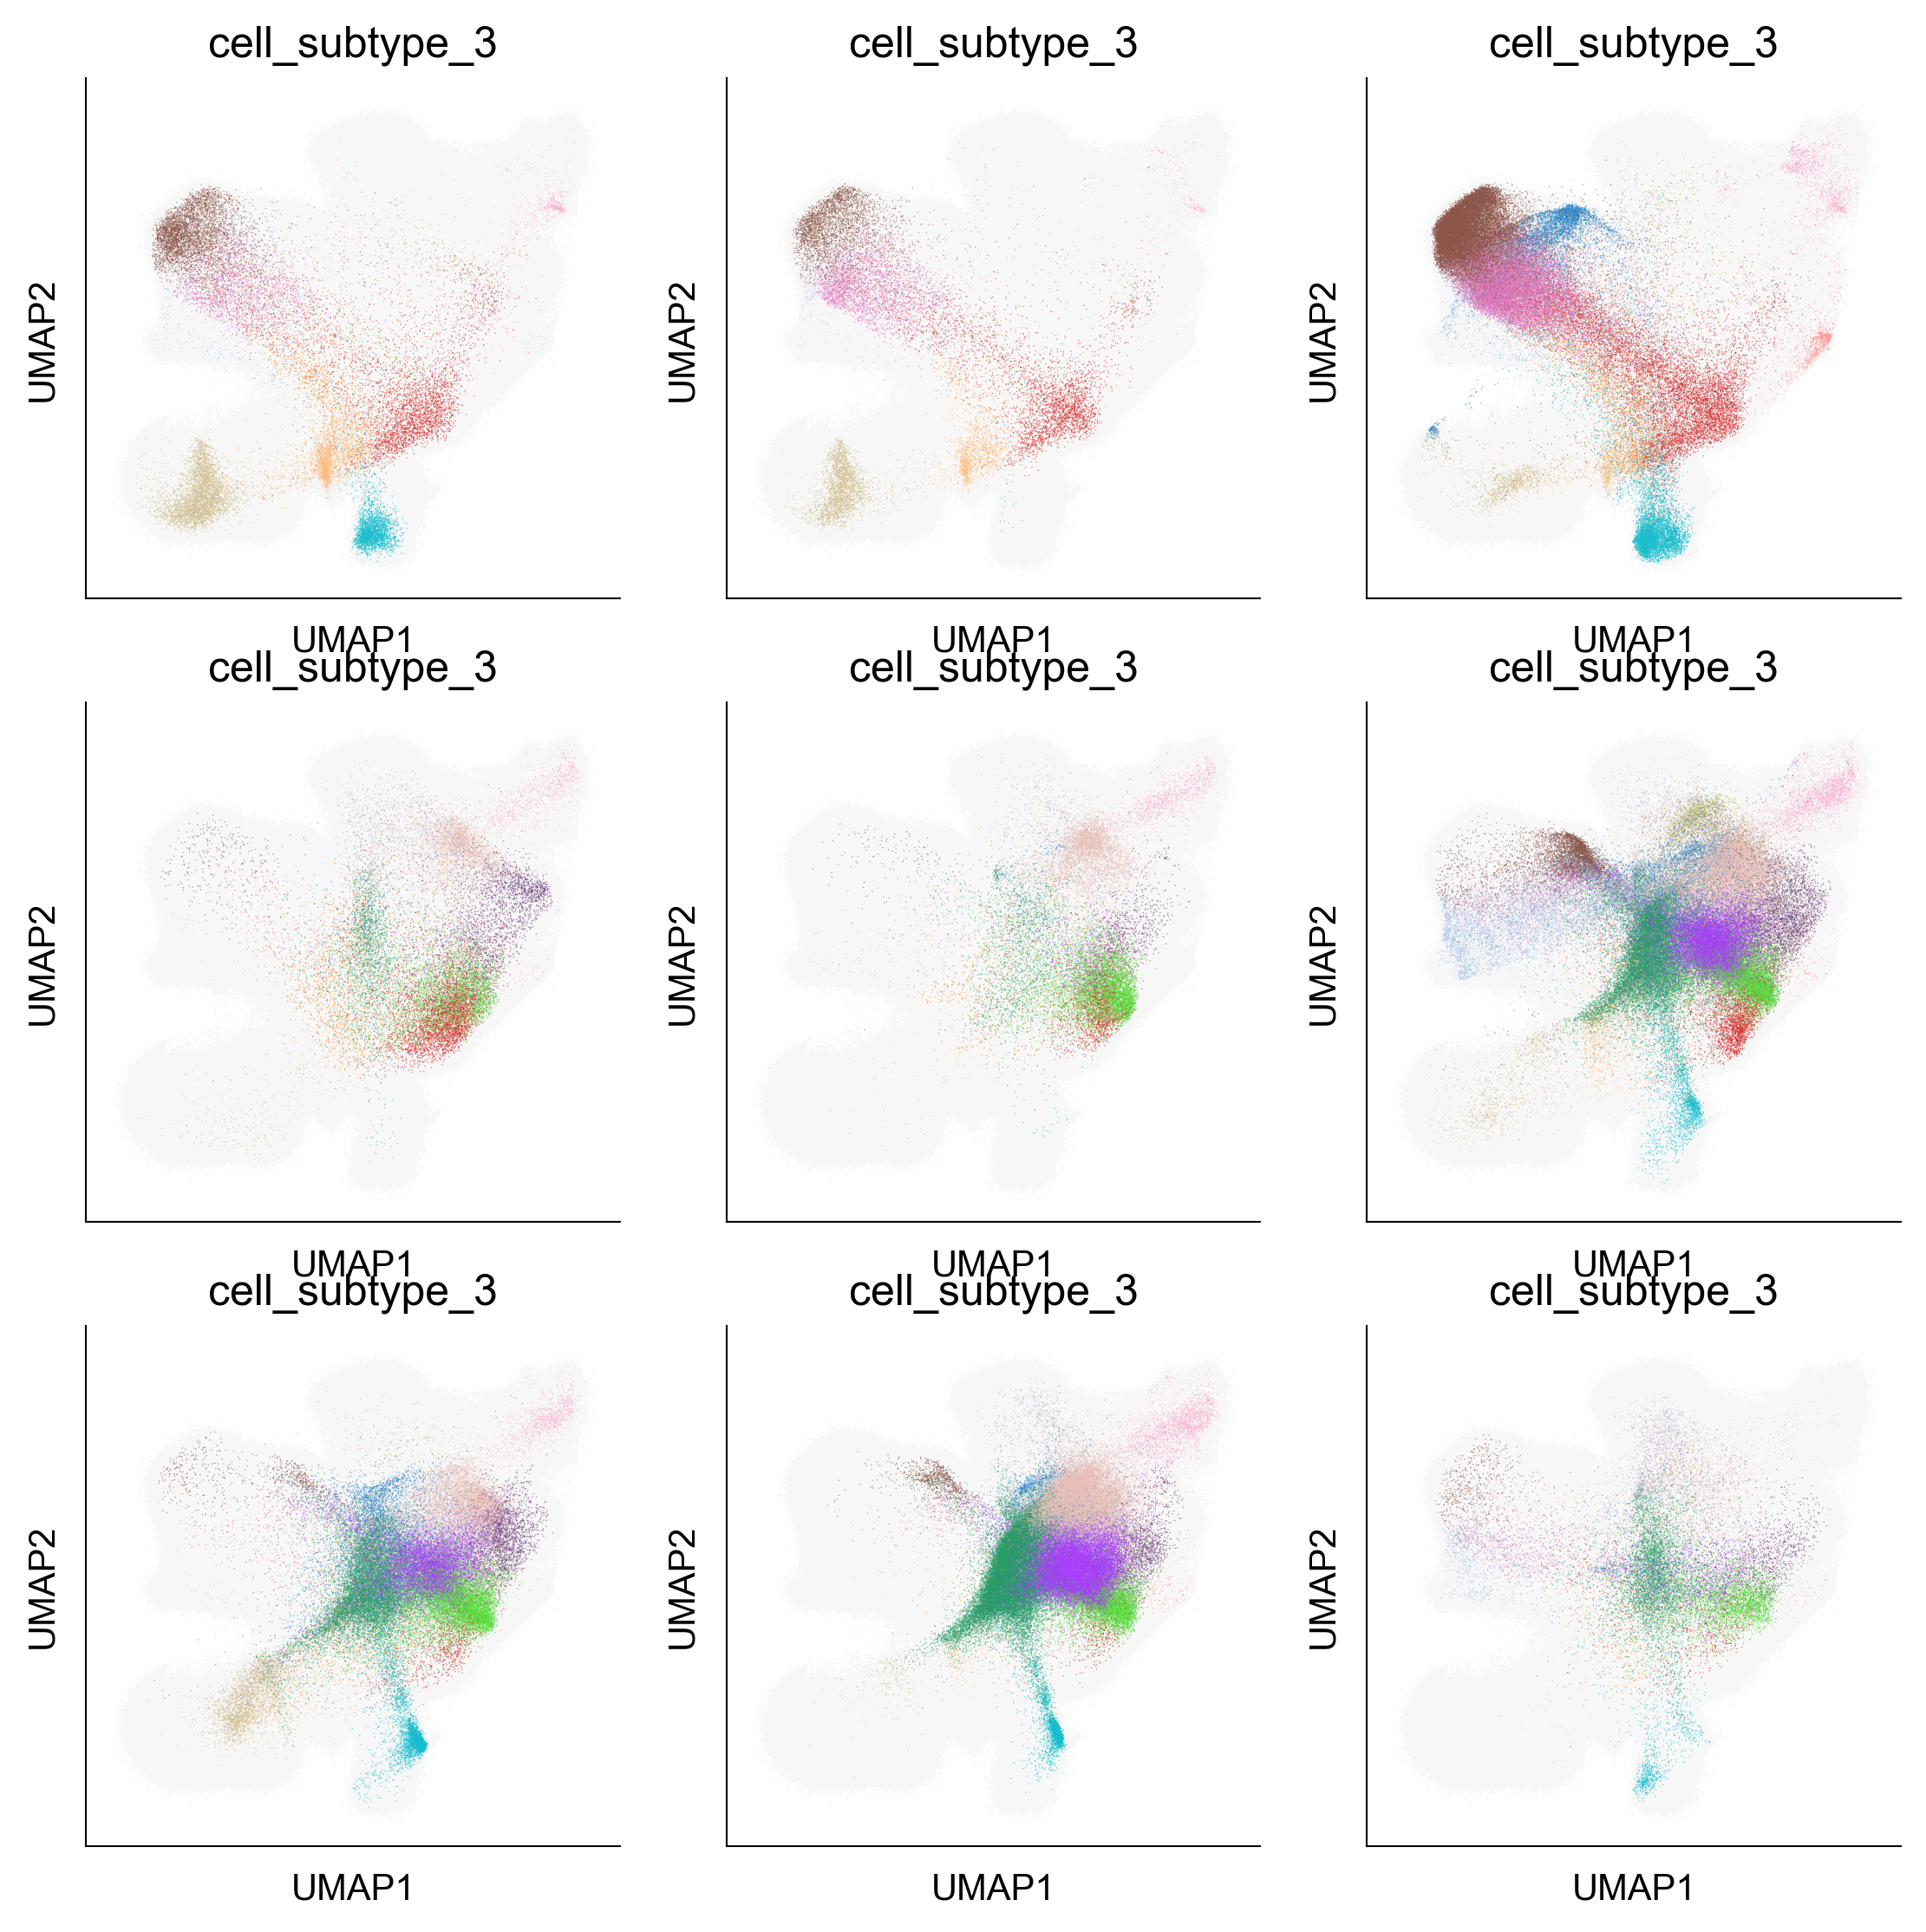

<Figure size 1800x1200 with 0 Axes>

In [58]:
fig,axes=createSubplots(3,3,figsize=(9,9))
axes=axes.flatten()

for ax, (i,j) in zip(axes, [
    ("PBMC", "Watson_2021"),
    ("PBMC", "Luoma_2022"),
    ("PBMC", "Zhang_2021"),
    ("TIL", "Bassez_2021"),
    ("TIL", "Luoma_2022"),
    ("TIL", "Liu_2021"),
    ("TIL", "Zhang_2021"),
    ("TIL", "Caushi_2021"),
    (["Inflamed","Uninflamed",'Healthy'], "Smillie_2019"),
]):
    print(j)
    if isinstance(i, str):
        i = [i]
    ax.scatter(
        obsm[:,0],
        obsm[:,1],
        lw=0,
        s=0.2,
        color='#F7F7F7'
    )
    sc.pl.umap(
        merged_adata_for_transfer[
            np.array(merged_adata_for_transfer.obs['tissue_type'].isin(i)) &
            np.array(merged_adata_for_transfer.obs['study_name'] == j)
        ],
        color='cell_subtype_3', 
        palette=subtype_color,
        ax=ax,
        s=0.5,
        alpha=0.6,
        show=False,
        legend_loc='none'
    )
plt.show()
plt.savefig("/Users/snow/Desktop/tmp.png")

### Clonotype sharing for transfered cell subtypes

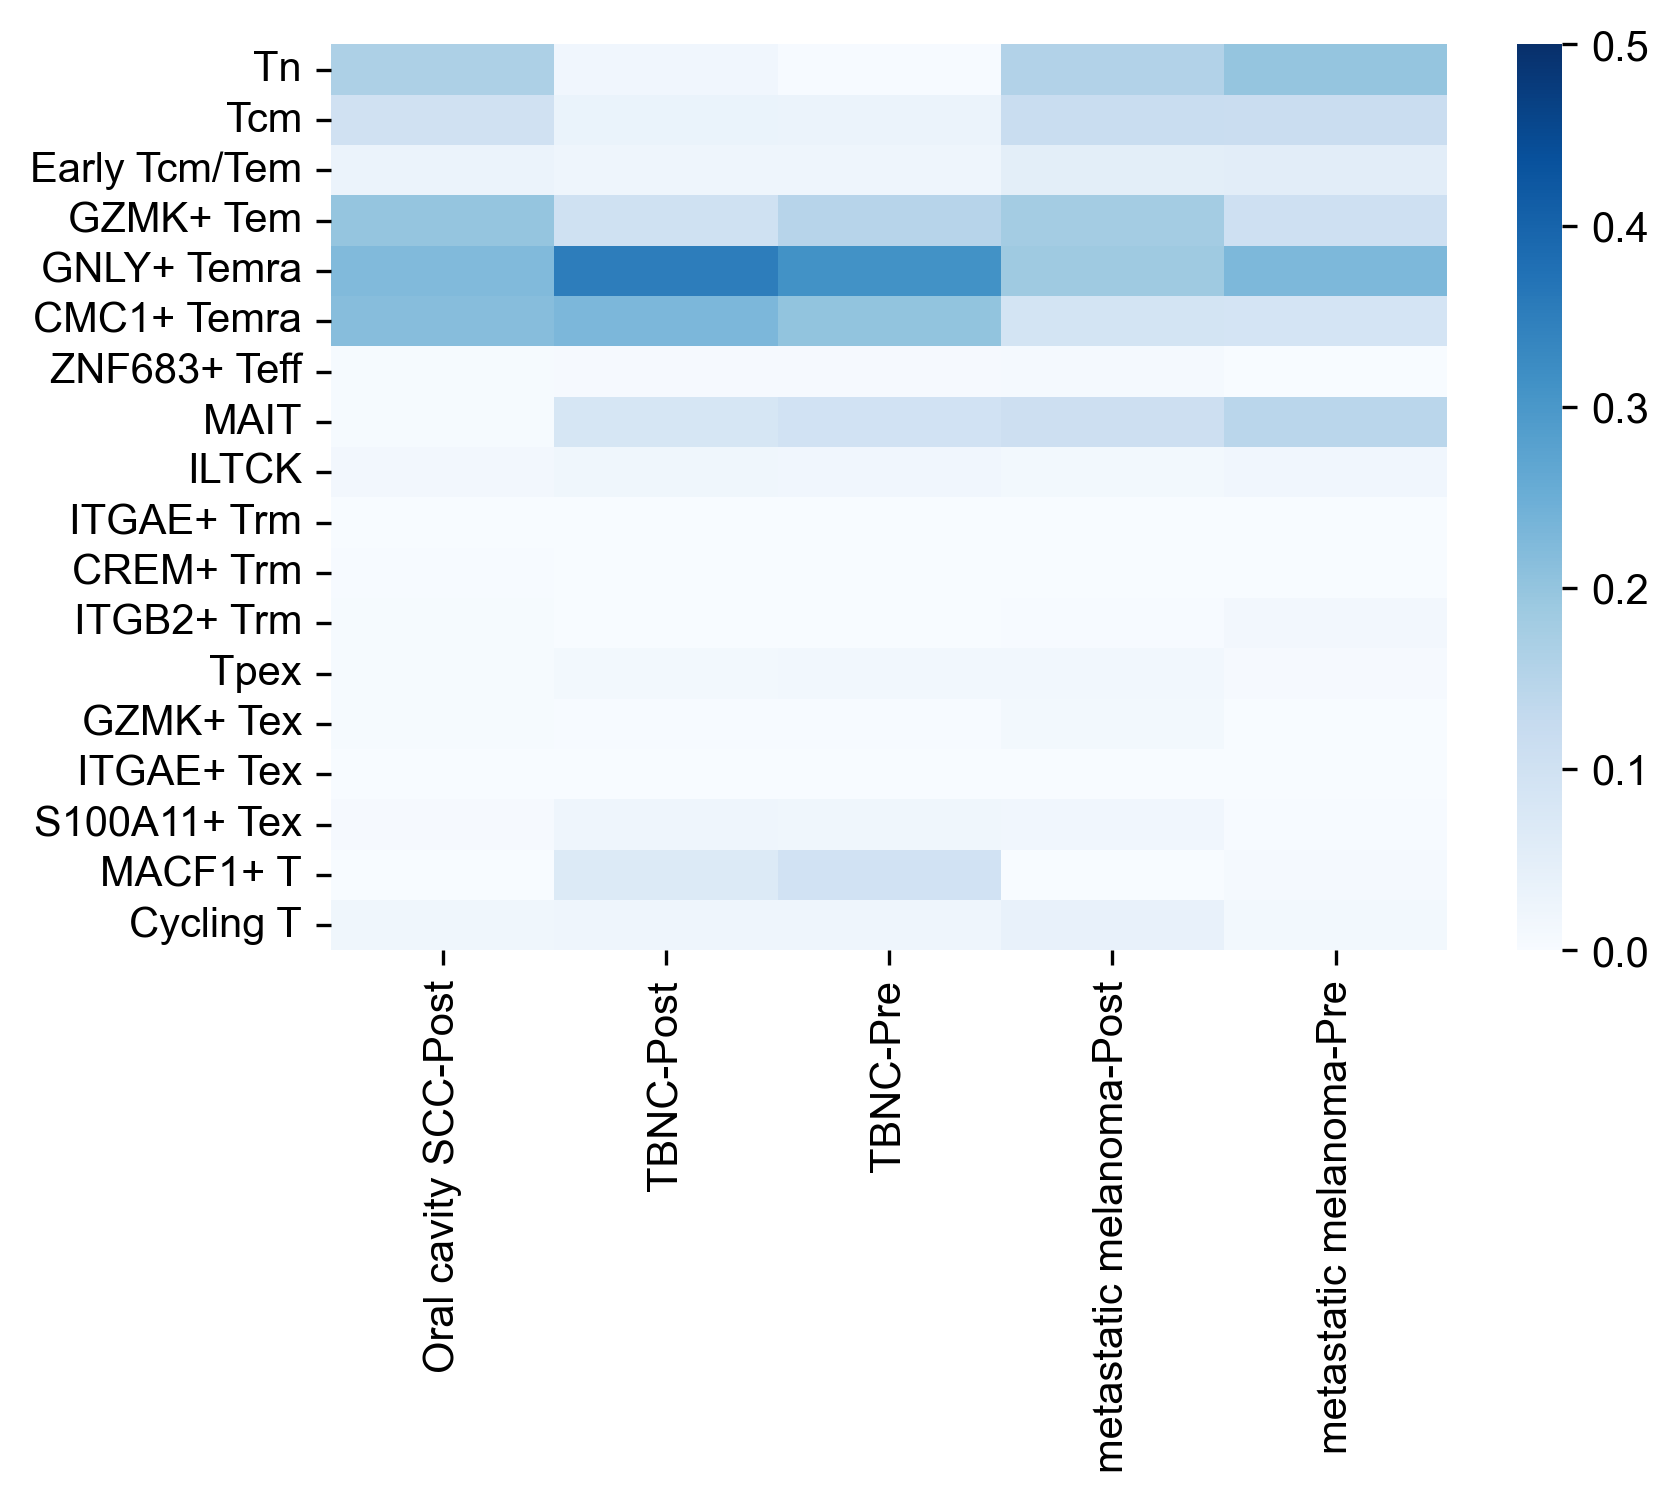

In [41]:
_merged_adata_for_transfer = merged_adata_for_transfer[
    np.array(merged_adata_for_transfer.obs['tissue_type'] == 'PBMC')
]
_merged_adata_for_transfer.obs['disease_treatment'] = list(map(lambda x: str(x[0]) + '-' + 'Pre' if 'naive' in x[1] else str(x[0]) + '-' + 'Post' , zip(_merged_adata_for_transfer.obs['disease_type'],_merged_adata_for_transfer.obs['treatment'])))
# sc.pl.umap(_merged_adata_for_transfer, color='cell_subtype_3', palette=subtype_color)


fraction, _ = plot_a_by_b(_merged_adata_for_transfer, a='cell_subtype_3', b='disease_treatment')
plt.close()
fraction.index=list(fraction.iloc[:,0])
fraction = fraction.iloc[:,1:]
sns.heatmap(fraction.T.loc[[
    'Tn',
    'Tcm',
    'Early Tcm/Tem',
    'GZMK+ Tem',
    'GNLY+ Temra',
    'CMC1+ Temra',
    'ZNF683+ Teff',
    'MAIT',
    'ILTCK',
    'ITGAE+ Trm',
    'CREM+ Trm',
    'ITGB2+ Trm',
    'Tpex',
    'GZMK+ Tex',
    'ITGAE+ Tex',
    'S100A11+ Tex',
    'MACF1+ T',
    'Cycling T'
]], cmap='Blues', xticklabels=1, yticklabels=1, vmax=0.5)

plt.savefig("./figures/transfered_dataset_solid_tumor_pbmc.pdf")

<AxesSubplot:>

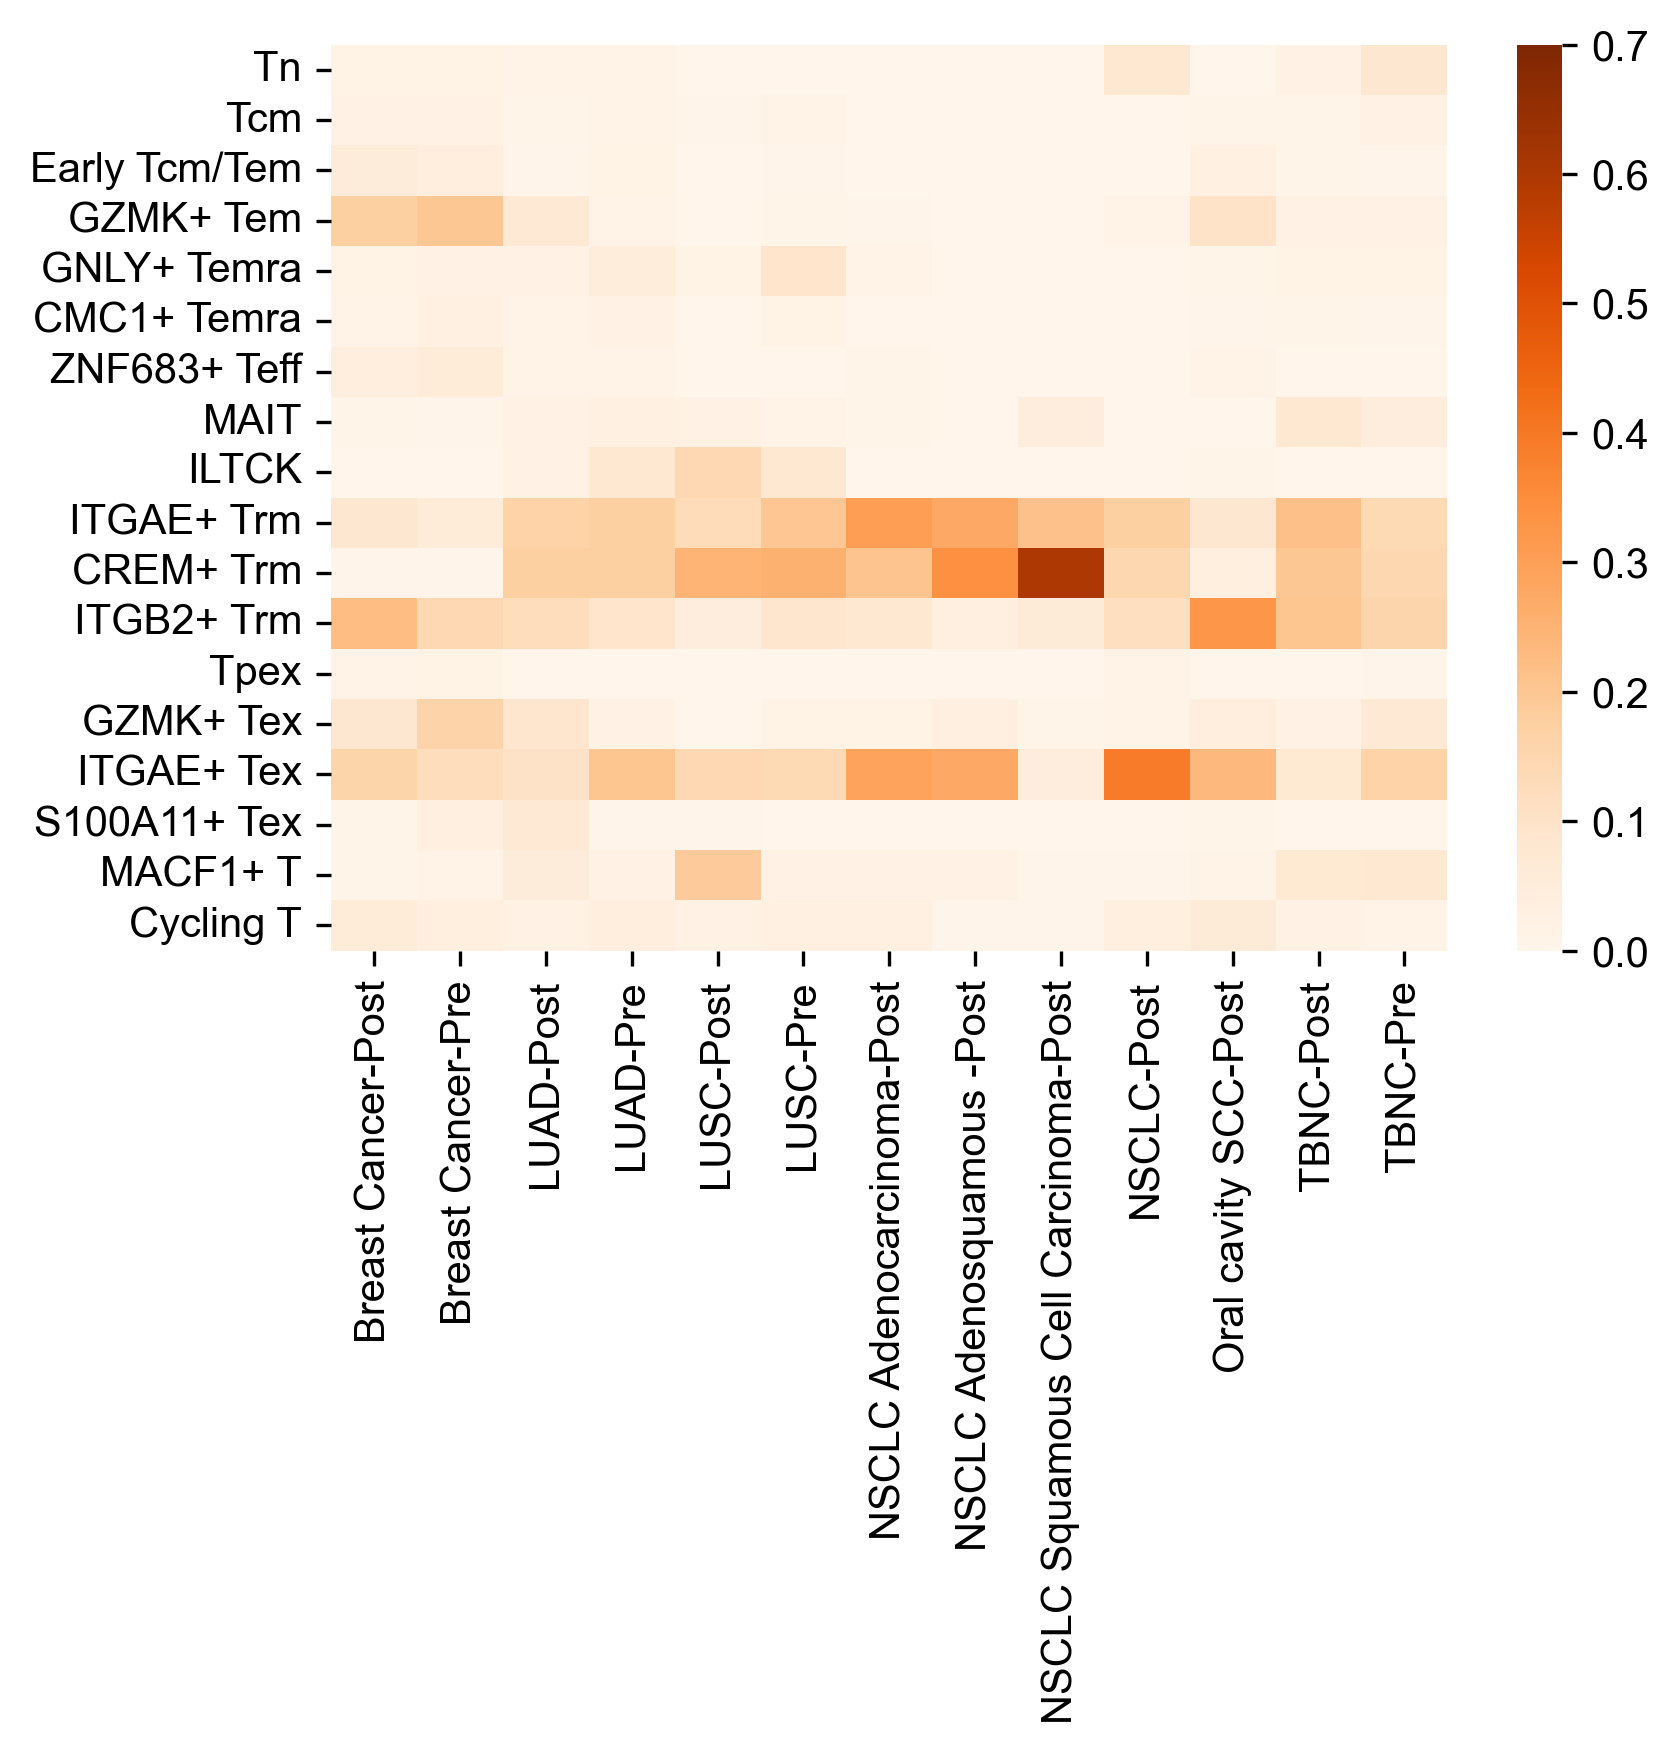

In [40]:
_merged_adata_for_transfer = merged_adata_for_transfer[
    np.array(merged_adata_for_transfer.obs['tissue_type'] == 'TIL')
]
_merged_adata_for_transfer.obs['disease_treatment'] = list(map(lambda x: str(x[0]) + '-' + 'Pre' if 'naive' in x[1] else str(x[0]) + '-' + 'Post' , zip(_merged_adata_for_transfer.obs['disease_type'],_merged_adata_for_transfer.obs['treatment'])))

#sc.pl.umap(_merged_adata_for_transfer, color='cell_subtype_3', palette=subtype_color)
    
fraction, _ = plot_a_by_b(_merged_adata_for_transfer, a='cell_subtype_3', b='disease_treatment')
plt.close()
fraction.index=list(fraction.iloc[:,0])
fraction = fraction.iloc[:,1:]
sns.heatmap(fraction.T.loc[[
    'Tn',
    'Tcm',
    'Early Tcm/Tem',
    'GZMK+ Tem',
    'GNLY+ Temra',
    'CMC1+ Temra',
    'ZNF683+ Teff',
    'MAIT',
    'ILTCK',
    'ITGAE+ Trm',
    'CREM+ Trm',
    'ITGB2+ Trm',
    'Tpex',
    'GZMK+ Tex',
    'ITGAE+ Tex',
    'S100A11+ Tex',
    'MACF1+ T',
    'Cycling T'

]], cmap='Oranges', xticklabels=1, yticklabels=1, vmax=0.7)



In [ ]:
## 

('GZMK+ Tex', 'GZMK+ Tem') 3 (3)
('GZMK+ Tex', 'ITGAE+ Trm') 2 (2)
('GZMK+ Tex', 'CREM+ Trm') 40 (40)
('GZMK+ Tex', 'ITGB2+ Trm') 18 (18)
('GZMK+ Tex', 'Cycling T') 2 (2)
('Early Tcm/Tem', 'ITGAE+ Tex') 2 (2)
('GZMK+ Tem', 'ITGAE+ Tex') 1 (1)
('ZNF683+ Teff', 'ITGAE+ Tex') 11 (11)
('MAIT', 'ITGAE+ Tex') 1 (1)
('ILTCK', 'ITGAE+ Tex') 4 (4)
('ITGAE+ Trm', 'ITGAE+ Tex') 349 (349)
('CREM+ Trm', 'ITGAE+ Tex') 127 (127)
('ITGB2+ Trm', 'ITGAE+ Tex') 5 (5)
('MACF1+ T', 'ITGAE+ Tex') 49 (49)
('Cycling T', 'ITGAE+ Tex') 92 (92)
----
('GZMK+ Tex', 'GZMK+ Tem') 1 (4)
('GZMK+ Tex', 'CREM+ Trm') 8 (48)
('GZMK+ Tex', 'ITGB2+ Trm') 6 (24)
('GZMK+ Tex', 'Cycling T') 1 (3)
('GNLY+ Temra', 'ITGAE+ Tex') 1 (1)
('ZNF683+ Teff', 'ITGAE+ Tex') 3 (14)
('ILTCK', 'ITGAE+ Tex') 1 (5)
('ITGAE+ Trm', 'ITGAE+ Tex') 27 (376)
('CREM+ Trm', 'ITGAE+ Tex') 19 (146)
('ITGB2+ Trm', 'ITGAE+ Tex') 5 (10)
('MACF1+ T', 'ITGAE+ Tex') 15 (64)
('Cycling T', 'ITGAE+ Tex') 60 (152)
----
('GZMK+ Tex', 'GZMK+ Tem') 1 (5)
('GZMK+ Tex

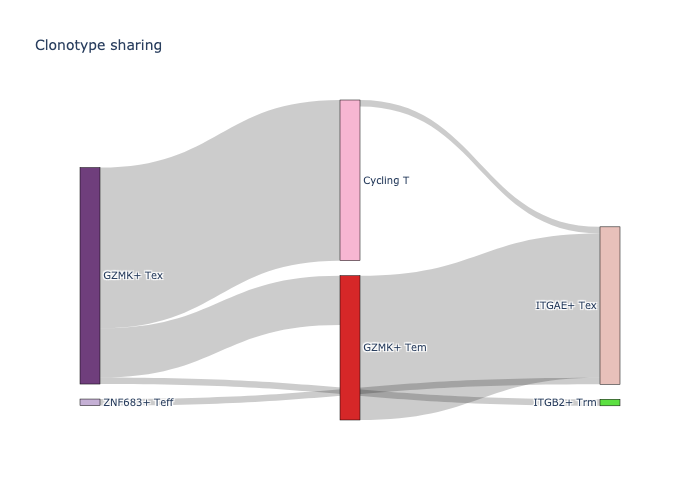

In [88]:
import plotly.graph_objects as go

all_count = {}
merged_adata_for_transfer_caushi_2021 = merged_adata_for_transfer[merged_adata_for_transfer.obs['study_name'] == 'Caushi_2021']
merged_adata_for_transfer_caushi_2021.obs['clonotype'] = list(map('='.join, merged_adata_for_transfer_caushi_2021.obs.loc[:,TRAB_DEFINITION_ORIG].to_numpy()))

clonotype_agg = merged_adata_for_transfer_caushi_2021.obs.groupby('clonotype').agg({
    "cell_subtype_3": Counter
})
sharing_dict = {'GZMK+ Tex': {k:0 for k in subtype_color.keys()}, 'ITGAE+ Tex': {k:0 for k in subtype_color.keys()}}
for i in clonotype_agg['cell_subtype_3']:
    if sum(list(i.values())) < 10:
        continue
    most_common = i.most_common()[:2]
    if any(list(map(lambda x: 'Tex' in x, list(map(lambda x: x[0], most_common))))):
        if not all(list(map(lambda x: 'Tex' in x, list(map(lambda x: x[0], most_common))))):
            most_common = dict(most_common)
            if 'ITGAE+ Tex' in most_common.keys():
                v = most_common.pop("ITGAE+ Tex")
                sharing_dict["ITGAE+ Tex"][list(most_common.keys())[0]] += 1
            elif 'GZMK+ Tex' in most_common.keys():
                most_common.pop("GZMK+ Tex")
                sharing_dict["GZMK+ Tex"][list(most_common.keys())[0]] += 1
                
                

count = {}

for k,v in sharing_dict.items():
    for i,j in v.items():
        if k == 'ITGAE+ Tex':
            count[(i,k)] = j
        else:
            count[(k,i)] = j
            
count = dict(list(filter(lambda x: x[1] > 0, count.items())))

for k,v in count.items():
    if k in all_count.keys():
        all_count[k] += v
    else:
        all_count[k] = v
        
    

for k,v in count.items():
    print(k,v, f'({all_count[k]})')
print("----")

merged_adata_for_transfer_liu_2021 = merged_adata_for_transfer[merged_adata_for_transfer.obs['study_name'] == 'Liu_2021']
merged_adata_for_transfer_liu_2021.obs['clonotype'] = list(map('='.join, merged_adata_for_transfer_liu_2021.obs.loc[:,TRAB_DEFINITION_ORIG].to_numpy()))

clonotype_agg = merged_adata_for_transfer_liu_2021.obs.groupby('clonotype').agg({
    "cell_subtype_3": Counter
})
sharing_dict = {'GZMK+ Tex': {k:0 for k in subtype_color.keys()}, 'ITGAE+ Tex': {k:0 for k in subtype_color.keys()}}
for i in clonotype_agg['cell_subtype_3']:
    if sum(list(i.values())) < 10:
        continue
    most_common = i.most_common()[:2]
    if any(list(map(lambda x: 'Tex' in x, list(map(lambda x: x[0], most_common))))):
        if not all(list(map(lambda x: 'Tex' in x, list(map(lambda x: x[0], most_common))))):
            most_common = dict(most_common)
            if 'ITGAE+ Tex' in most_common.keys():
                most_common.pop("ITGAE+ Tex")
                sharing_dict["ITGAE+ Tex"][list(most_common.keys())[0]] += 1
            elif 'GZMK+ Tex' in most_common.keys():
                most_common.pop("GZMK+ Tex")
                sharing_dict["GZMK+ Tex"][list(most_common.keys())[0]] += 1
                
                
count = {}


for k,v in sharing_dict.items():
    for i,j in v.items():
        if k == 'ITGAE+ Tex':
            count[(i,k)] = j
        else:
            count[(k,i)] = j
            
count = dict(list(filter(lambda x: x[1] > 0, count.items())))

for k,v in count.items():
    if k in all_count.keys():
        all_count[k] += v
    else:
        all_count[k] = v
        
    

for k,v in count.items():
    print(k,v, f'({all_count[k]})')

print("----")

merged_adata_for_transfer_luoma_2022 = merged_adata_for_transfer[merged_adata_for_transfer.obs['study_name'] == 'Luoma_2022']
merged_adata_for_transfer_luoma_2022 = merged_adata_for_transfer_luoma_2022[
    list(map(lambda x: all(map(lambda z: type(z) == str, x)), merged_adata_for_transfer_luoma_2022.obs.loc[:,TRAB_DEFINITION_ORIG].to_numpy()))
]
merged_adata_for_transfer_luoma_2022.obs['clonotype'] = list(map('='.join, merged_adata_for_transfer_luoma_2022.obs.loc[:,TRAB_DEFINITION_ORIG].to_numpy()))

clonotype_agg = merged_adata_for_transfer_luoma_2022.obs.groupby('clonotype').agg({
    "cell_subtype_3": Counter
})
sharing_dict = {'GZMK+ Tex': {k:0 for k in subtype_color.keys()}, 'ITGAE+ Tex': {k:0 for k in subtype_color.keys()}}
for i in clonotype_agg['cell_subtype_3']:
    if sum(list(i.values())) < 10:
        continue
    most_common = i.most_common()[:2]
    if any(list(map(lambda x: 'Tex' in x, list(map(lambda x: x[0], most_common))))):
        if not all(list(map(lambda x: 'Tex' in x, list(map(lambda x: x[0], most_common))))):
            most_common = dict(most_common)
            if 'ITGAE+ Tex' in most_common.keys():
                most_common.pop("ITGAE+ Tex")
                sharing_dict["ITGAE+ Tex"][list(most_common.keys())[0]] += 1
            elif 'GZMK+ Tex' in most_common.keys():
                most_common.pop("GZMK+ Tex")
                sharing_dict["GZMK+ Tex"][list(most_common.keys())[0]] += 1
                
                

count = {}
labels = list(subtype_color.keys())
for k,v in sharing_dict.items():
    for i,j in v.items():
        if k == 'ITGAE+ Tex':
            count[(i,k)] = j
        else:
            count[(k,i)] = j
            
count = dict(list(filter(lambda x: x[1] > 0, count.items())))

for k,v in count.items():
    if k in all_count.keys():
        all_count[k] += v
    else:
        all_count[k] = v
        
    

for k,v in count.items():
    print(k,v, f'({all_count[k]})')
    
print("-----")

merged_adata_for_transfer_bassez_2021 = merged_adata_for_transfer[merged_adata_for_transfer.obs['study_name'] == 'Bassez_2021']
merged_adata_for_transfer_bassez_2021 = merged_adata_for_transfer_bassez_2021[
    list(map(lambda x: all(map(lambda z: type(z) == str, x)), merged_adata_for_transfer_bassez_2021.obs.loc[:,['IR_VJ_1_junction_aa','IR_VDJ_1_junction_aa']].to_numpy()))
]
merged_adata_for_transfer_bassez_2021.obs['clonotype'] = list(map('='.join, merged_adata_for_transfer_bassez_2021.obs.loc[:,['IR_VJ_1_junction_aa','IR_VDJ_1_junction_aa']].to_numpy()))

clonotype_agg = merged_adata_for_transfer_bassez_2021.obs.groupby('clonotype').agg({
    "cell_subtype_3": Counter
})
sharing_dict = {'GZMK+ Tex': {k:0 for k in subtype_color.keys()}, 'ITGAE+ Tex': {k:0 for k in subtype_color.keys()}}
for i in clonotype_agg['cell_subtype_3']:
    if sum(list(i.values())) < 10:
        continue
    most_common = i.most_common()[:2]
    if any(list(map(lambda x: 'Tex' in x, list(map(lambda x: x[0], most_common))))):
        if not all(list(map(lambda x: 'Tex' in x, list(map(lambda x: x[0], most_common))))):
            most_common = dict(most_common)
            if 'ITGAE+ Tex' in most_common.keys():
                most_common.pop("ITGAE+ Tex")
                sharing_dict["ITGAE+ Tex"][list(most_common.keys())[0]] += 1
            elif 'GZMK+ Tex' in most_common.keys():
                most_common.pop("GZMK+ Tex")
                sharing_dict["GZMK+ Tex"][list(most_common.keys())[0]] += 1
                
                

count = {}
for k,v in sharing_dict.items():
    for i,j in v.items():
        if k == 'ITGAE+ Tex':
            count[(i,k)] = j
        else:
            count[(k,i)] = j
            
count = dict(list(filter(lambda x: x[1] > 0, count.items())))

for k,v in count.items():
    if k in all_count.keys():
        all_count[k] += v
    else:
        all_count[k] = v
        

for k,v in count.items():
    print(k,v, f'({all_count[k]})')

all_count = dict(list(filter(lambda x: 'Cycling T' not in x[0], all_count.items())))
    
labels = list(subtype_color.keys())
fig = go.Figure(data=[go.Sankey(
    arrangement='snap',  
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = labels,
      color = list(subtype_color.values()),
    ),
    link = dict(
      source = list(map(lambda x: labels.index(x), list(map(lambda z: z[0], count.keys())))), # indices correspond to labels, eg A1, A2, A1, B1, ...
      target = list(map(lambda x: labels.index(x), list(map(lambda z: z[1], count.keys())))),
      value = list(all_count.values()),
  ))])

fig.update_layout(title_text="Clonotype sharing", font_size=10)
fig.show(renderer="png")